# Fashion Recommendation System using CNN and Neural Network Embeddings

### Introduction

In this notebook, I will be building a fashion recommendation system that will suggest similar clothes based on their description ( i.e colour, category). To create this I will be using convolutional neural network (CNN) and neural network embedding. 
An increasing number of online fashion companies are utilizing recommendation systems to increase user interaction and enhance the shopping experience. Companies like ASOS and Zalando have a massive offering of clothes and accessories. Although these companies give customers a wider range of clothes to choose from, they may become overwhelmed and have a difficult time making a decision when faced with many options. This is where recommendation systems step in, it suggest the most relevant items to buy and, as a result, increase a company’s revenue. 


### Approach

The dataset being used is from University of Modena and Reggio Emilia’s Imagelab. It contains over 60,000 images of clothes and accessories. For this project I used 7,500 due to computational limitations.
The plan is to use CNN to classify the clothing images into categorical labels and use the feature layer as the deep features of the images. The feature layer will be able to capture features of the clothes, like the categories, colour, and patterns. Then use entity embeddings to map high-dimensional categorical variables to a low-dimensional learned representation that places similar entities closer together in the embedding space.Therefore, the basic approach for a recommendation system is to create fashion embeddings of all the clothing images, and then for any item of clothing, find the most similar clothes in the embedding space.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
tf.__version__
import cv2
import cv2 as cv
import pytesseract
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [4]:
data = pd.read_csv('/Users/flatironschool/Downloads/annotation.txt', sep=None, engine='python',nrows=7500)

In [5]:
# Fashion clothes dataset
data.head()

,filename,color,micro_category,macro_category,macro_category(english),Unnamed: 5,Unnamed: 6,Unnamed: 7
0,35154736FEF.jpg,BRONZO,GONNA PELLE,ABBIGLIAMENTO PELLE,leather,NaN,NaN,NaN
1,35157444XDF.jpg,PLATINO,GONNA PELLE,ABBIGLIAMENTO PELLE,leather,NaN,NaN,NaN
2,35157749QFF.jpg,NOCCIOLA,GONNA PELLE,ABBIGLIAMENTO PELLE,leather,NaN,NaN,NaN
3,35165506NDF.jpg,ORO,GONNA PELLE,ABBIGLIAMENTO PELLE,leather,NaN,NaN,NaN
4,35167181CRF.jpg,ANTRACITE,GONNA PELLE,ABBIGLIAMENTO PELLE,leather,NaN,NaN,NaN


### Data Cleaning

In [6]:
# drop unecessary columns with null values
data.drop(columns=['Unnamed: 5','Unnamed: 6','Unnamed: 7'],inplace=True)

In [7]:
data.isnull().any()

filename                   False
color                      False
micro_category             False
macro_category             False
macro_category(english)    False
dtype: bool

Exploring the data, I  want to find the number of unique macro and mirco categories and the most common ones 

In [8]:
data['macro_category(english)'].unique()

array(['leather', 'suits', 'accessories', 'diaries', 'nursing',
       'furniture', 'bags', 'footwear'], dtype=object)

In [9]:
data['macro_category(english)'].value_counts()

footwear       4021
accessories    1557
bags            974
leather         840
suits            79
furniture        23
nursing           4
diaries           2
Name: macro_category(english), dtype: int64

Since a fashion recommendation is being built, We want to remove furniture and nursing products from the dataset 

In [10]:
data=data[data['macro_category(english)'] != 'nursing'].reset_index(drop=True)

In [11]:
data=data[data['macro_category(english)'] != 'furniture'].reset_index(drop=True)

In [12]:
data.head(-1)

,filename,color,micro_category,macro_category,macro_category(english)
0,35154736FEF.jpg,BRONZO,GONNA PELLE,ABBIGLIAMENTO PELLE,leather
1,35157444XDF.jpg,PLATINO,GONNA PELLE,ABBIGLIAMENTO PELLE,leather
2,35157749QFF.jpg,NOCCIOLA,GONNA PELLE,ABBIGLIAMENTO PELLE,leather
3,35165506NDF.jpg,ORO,GONNA PELLE,ABBIGLIAMENTO PELLE,leather
4,35167181CRF.jpg,ANTRACITE,GONNA PELLE,ABBIGLIAMENTO PELLE,leather
...,...,...,...,...,...
7467,44360976IAF.jpg,ROSA CHIARO,SANDALI CON PLATEAU,CALZATURE,footwear
7468,44360978XUF.jpg,OCRA,DECOLLETES CON PLATEAU,CALZATURE,footwear
7469,44360987OSF.jpg,BORDEAUX,SNEAKERS,CALZATURE,footwear
7470,44360993XPF.jpg,CACAO,ZEPPE,CALZATURE,footwear


In [13]:
data.micro_category.unique()

array(['GONNA PELLE', 'PANTALONE PELLE', 'CAPOSPALLA PELLE',
       'CAPISPALLA PELLICCIA', 'GILET', 'ABITO', 'COLLI', 'CINTURA',
       'SCIARPA', 'SCIALLE', 'OCCHIALI', 'PORTACHIAVI', 'CAPPELLO',
       'PORTAMONETE', 'CRAVATTA', 'PORTAFOGLIO', 'GUANTI', 'FOULARD',
       'STOLA', 'Accessori per capelli', 'PORTADOCUMENTI', 'Bustina',
       'MANICHE', 'FIBBIE', 'BRETELLE', 'PAPILLON', 'PORTA-AGENDA',
       'OMBRELLO', 'Taccuini', 'Agende', 'BORSA GRANDE IN TESSUTO',
       'BORSA PICCOLA IN PELLE', 'BORSA GRANDE IN PELLE',
       'BORSA MEDIA IN TESSUTO', 'BORSA MEDIA IN PELLE', 'POCHETTE',
       'BORSA PICCOLA IN TESSUTO', 'MARSUPIO', 'ZAINO', 'ZEPPE',
       'BALLERINA', 'SNEAKERS', 'STIVALETTI', 'SANDALI CON TACCO',
       'DECOLLETES', 'SANDALI', 'MOCASSINI ', 'DECOLLETES CON PLATEAU',
       'INFRADITO', 'SANDALI CON PLATEAU', 'DECOLLETES OPEN TOE',
       'STRINGATA', 'STIVALI', 'CIABATTE', 'Peep-toe ballet flats',
       'Decolletes slingback', 'SNEAKER ALTA', 'BABBUCCE',
  

The micro category is in Italian. For me to interpret the descriptions, it needs to be translated to english 

In [14]:
# Translating italian micro category into english 
data=data.replace(to_replace =['GONNA PELLE', 'PANTALONE PELLE', 'CAPOSPALLA PELLE',
       'CAPISPALLA PELLICCIA', 'GILET', 'ABITO', 'COLLI', 'CINTURA',
       'SCIARPA', 'SCIALLE', 'OCCHIALI', 'PORTACHIAVI', 'CAPPELLO',
       'PORTAMONETE', 'CRAVATTA', 'PORTAFOGLIO', 'GUANTI', 'FOULARD',
       'STOLA', 'Accessori per capelli', 'PORTADOCUMENTI', 'Bustina',
       'MANICHE', 'FIBBIE', 'BRETELLE', 'PAPILLON', 'PORTA-AGENDA',
       'OMBRELLO', 'Taccuini', 'Agende', 'BORSA GRANDE IN TESSUTO',
       'BORSA PICCOLA IN PELLE', 'BORSA GRANDE IN PELLE',
       'BORSA MEDIA IN TESSUTO', 'BORSA MEDIA IN PELLE', 'POCHETTE',
       'BORSA PICCOLA IN TESSUTO', 'MARSUPIO', 'ZAINO', 'ZEPPE',
       'BALLERINA', 'SNEAKERS', 'STIVALETTI', 'SANDALI CON TACCO',
       'DECOLLETES', 'SANDALI', 'MOCASSINI ', 'DECOLLETES CON PLATEAU',
       'INFRADITO', 'SANDALI CON PLATEAU', 'DECOLLETES OPEN TOE',
       'STRINGATA', 'STIVALI', 'CIABATTE', 'Peep-toe ballet flats',
       'Decolletes slingback', 'SNEAKER ALTA', 'BABBUCCE',
       'STIVALI CON TACCO', 'SNEAKER SLIP ON', 'MOCASSINI CON TACCO',
       'SABOT', 'POLACCHINA', 'SHOE BOOTS', 'ANFIBI', 'PANTOFOLE'],  
                            value =['LEATHER SKIRT', 'LEATHER TROUSERS', 'LEATHER OUTERWEAR',
'FUR COATS', 'VESTS', 'DRESS', 'COLLI', 'BELT',
'SCARF', 'SHAWL', 'GLASSES', 'KEYCHAIN', 'HAT',
'PURSE', 'TIE', 'WALLET', 'GLOVES', 'FOULARD',
'STOLA', 'Hair accessories', 'DOCUMENT HOLDER', 'Sachet',
'SLEEVES', 'BUCKLES', 'BRACES', 'PAPILLON', 'BOOK-HOLDER',
'UMBRELLA', 'Notebooks', 'Agendas', 'LARGE FABRIC BAG',
'SMALL LEATHER BAG', 'LARGE LEATHER BAG',
'MEDIUM FABRIC BAG', 'MEDIUM LEATHER BAG', 'CLUTCH',
'SMALL FABRIC BAG', 'BABY BAG', 'BACKPACK', 'WEDGES',
'BALLERINA', 'SNEAKERS', 'ANKLE BOOTS', 'SANDALS WITH HEEL',
'DECOLLETES', 'SANDALS', 'LOAFERS', 'DECOLLETES WITH PLATEAU',
'FLIP FLOPS', 'SANDALS WITH PLATEAU', 'DECOLLETES OPEN TOE',
'LACE UP', 'BOOTS', 'SLIPPERS', 'Peep-toe ballet flats',
'Decolletes slingback', 'HIGH SNEAKER', 'BABBUCCE',
'BOOTS WITH HEEL', 'SNEAKER SLIP ON', 'LOAFERS WITH HEEL',
'SABOT', 'POLACCHINA', 'SHOE BOOTS', 'ANFIBI', 'SLIPPERS'])

In [15]:
data['micro_category'] = data['micro_category'].str.strip()

In [16]:
data.micro_category.unique()

array(['LEATHER SKIRT', 'LEATHER TROUSERS', 'LEATHER OUTERWEAR',
       'FUR COATS', 'VESTS', 'DRESS', 'COLLI', 'BELT', 'SCARF', 'SHAWL',
       'GLASSES', 'KEYCHAIN', 'HAT', 'PURSE', 'TIE', 'WALLET', 'GLOVES',
       'FOULARD', 'STOLA', 'Hair accessories', 'DOCUMENT HOLDER',
       'Sachet', 'SLEEVES', 'BUCKLES', 'BRACES', 'PAPILLON',
       'BOOK-HOLDER', 'UMBRELLA', 'Notebooks', 'Agendas',
       'LARGE FABRIC BAG', 'SMALL LEATHER BAG', 'LARGE LEATHER BAG',
       'MEDIUM FABRIC BAG', 'MEDIUM LEATHER BAG', 'CLUTCH',
       'SMALL FABRIC BAG', 'BABY BAG', 'BACKPACK', 'WEDGES', 'BALLERINA',
       'SNEAKERS', 'ANKLE BOOTS', 'SANDALS WITH HEEL', 'DECOLLETES',
       'SANDALS', 'LOAFERS', 'DECOLLETES WITH PLATEAU', 'FLIP FLOPS',
       'SANDALS WITH PLATEAU', 'DECOLLETES OPEN TOE', 'LACE UP', 'BOOTS',
       'SLIPPERS', 'Peep-toe ballet flats', 'Decolletes slingback',
       'HIGH SNEAKER', 'BABBUCCE', 'BOOTS WITH HEEL', 'SNEAKER SLIP ON',
       'LOAFERS WITH HEEL', 'SABOT', 'POLACCHIN

The colours column is also in italian, this needs to be transalted to English too.

In [17]:
data.color.unique()

array(['BRONZO', 'PLATINO', 'NOCCIOLA', 'ORO', 'ANTRACITE', 'NERO',
       'GRIGIO CHIARO', 'COLONIALE', 'BORDEAUX', 'VERDE PETROLIO',
       'CAMMELLO', 'TORTORA', 'MARRONE', 'GIALLO CHIARO', 'RUGGINE',
       'CORALLO', 'CACAO', 'AVIO', 'ARGENTO', 'TURCHESE', 'VERDE SCURO',
       'VIOLA', 'ROSA', 'GIALLO', 'CUOIO', 'MELANZANA', 'AVORIO', 'ROSSO',
       'GRIGIO', 'BEIGE', 'TESTA DI MORO', 'RAME', 'ALBICOCCA', 'SALMONE',
       'VERDE SMERALDO', 'OCRA', 'CARNE', 'MATTONE', 'VIOLA CHIARO',
       'VIOLA SCURO', 'BLU CHINA', 'MALVA', 'ROSA ANTICO', 'VERDE ACIDO',
       'CELESTE', 'ARANCIONE', 'VERDE CHIARO', 'VERDE', 'SABBIA', 'LILLA',
       'AZZURRO', 'VERDE MILITARE', 'PIOMBO', 'CARTA DA ZUCCHERO',
       'BLU SCURO', 'FUCSIA', 'BLU', 'PORPORA', 'BIANCO', 'TRASPARENTE',
       'ROSA CHIARO'], dtype=object)

In [18]:
# Translating colours in itaian into english 

data=data.replace(to_replace =['BRONZO', 'PLATINO', 'NOCCIOLA', 'ORO', 'ANTRACITE', 'NERO',
       'GRIGIO CHIARO', 'COLONIALE', 'BORDEAUX', 'VERDE PETROLIO',
       'CAMMELLO', 'TORTORA', 'MARRONE', 'GIALLO CHIARO', 'RUGGINE',
       'CORALLO', 'CACAO', 'AVIO', 'ARGENTO', 'TURCHESE', 'VERDE SCURO',
       'VIOLA', 'ROSA', 'GIALLO', 'CUOIO', 'MELANZANA', 'AVORIO', 'ROSSO',
       'GRIGIO', 'BEIGE', 'TESTA DI MORO', 'RAME', 'ALBICOCCA', 'SALMONE',
       'VERDE SMERALDO', 'OCRA', 'CARNE', 'MATTONE', 'VIOLA CHIARO',
       'VIOLA SCURO', 'BLU CHINA', 'MALVA', 'ROSA ANTICO', 'VERDE ACIDO',
       'CELESTE', 'ARANCIONE', 'VERDE CHIARO', 'VERDE', 'SABBIA', 'LILLA',
       'AZZURRO', 'VERDE MILITARE', 'PIOMBO', 'CARTA DA ZUCCHERO',
       'BLU SCURO', 'FUCSIA', 'BLU', 'PORPORA', 'BIANCO', 'TRASPARENTE',
       'ROSA CHIARO'],  
                            value =['BRONZE', 'PLATINUM', 'HAZELNUT', 'GOLD', 'ANTHRACITE', 'BLACK',
'LIGHT GRAY', 'COLONIAL', 'BORDEAUX', 'GREEN PETROLEUM',
'CAMEL', 'TAUPE', 'BROWN', 'LIGHT YELLOW', 'RUST',
'CORAL', 'COCOA', 'AVIO', 'SILVER', 'TURQUOISE', 'DARK GREEN',
'PURPLE', 'PINK', 'YELLOW', 'LEATHER', 'EGGPLANT', 'IVORY', 'RED',
'GRAY', 'BEIGE', 'DARK BROWN', 'COPPER', 'APRICOT', 'SALMON',
'GREEN EMERALD', 'OCHER', 'MEAT', 'BRICK', 'LIGHT PURPLE',
'DARK PURPLE', 'BLU CHINA', 'MALVA', 'ANTIQUE PINK', 'ACID GREEN',
'LIGHT BLUE', 'ORANGE', 'LIGHT GREEN', 'GREEN', 'SAND', 'LILAC',
'LIGHT BLUE', 'MILITARY GREEN', 'LEAD', 'SUGAR PAPER',
'DARK BLUE', 'FUCHSIA', 'BLUE', 'PURPLE', 'WHITE', 'TRANSPARENT',
'LIGHT PINK'])

In [19]:
data.color.unique()

array(['BRONZE', 'PLATINUM', 'HAZELNUT', 'GOLD', 'ANTHRACITE', 'BLACK',
       'LIGHT GRAY', 'COLONIAL', 'BORDEAUX', 'GREEN PETROLEUM', 'CAMEL',
       'TAUPE', 'BROWN', 'LIGHT YELLOW', 'RUST', 'CORAL', 'COCOA', 'AVIO',
       'SILVER', 'TURQUOISE', 'DARK GREEN', 'PURPLE', 'PINK', 'YELLOW',
       'LEATHER', 'EGGPLANT', 'IVORY', 'RED', 'GRAY', 'BEIGE',
       'DARK BROWN', 'COPPER', 'APRICOT', 'SALMON', 'GREEN EMERALD',
       'OCHER', 'MEAT', 'BRICK', 'LIGHT PURPLE', 'DARK PURPLE',
       'BLU CHINA', 'MALVA', 'ANTIQUE PINK', 'ACID GREEN', 'LIGHT BLUE',
       'ORANGE', 'LIGHT GREEN', 'GREEN', 'SAND', 'LILAC',
       'MILITARY GREEN', 'LEAD', 'SUGAR PAPER', 'DARK BLUE', 'FUCHSIA',
       'BLUE', 'WHITE', 'TRANSPARENT', 'LIGHT PINK'], dtype=object)

The filenames need to changed to match the names of the images in my local drive

In [21]:
data.filename=data4['filename'].apply(lambda x: x[:-4] )

In [22]:
data.filename=data4['filename'].apply(lambda x: x + "_resized.jpg")

In [23]:
data.head(-1)

,filename,color,micro_category,macro_category,macro_category(english)
0,35154736FEF_resized.jpg,BRONZE,LEATHER SKIRT,ABBIGLIAMENTO PELLE,leather
1,35157444XDF_resized.jpg,PLATINUM,LEATHER SKIRT,ABBIGLIAMENTO PELLE,leather
2,35157749QFF_resized.jpg,HAZELNUT,LEATHER SKIRT,ABBIGLIAMENTO PELLE,leather
3,35165506NDF_resized.jpg,GOLD,LEATHER SKIRT,ABBIGLIAMENTO PELLE,leather
4,35167181CRF_resized.jpg,ANTHRACITE,LEATHER SKIRT,ABBIGLIAMENTO PELLE,leather
...,...,...,...,...,...
7467,44360976IAF_resized.jpg,LIGHT PINK,SANDALS WITH PLATEAU,CALZATURE,footwear
7468,44360978XUF_resized.jpg,OCHER,DECOLLETES WITH PLATEAU,CALZATURE,footwear
7469,44360987OSF_resized.jpg,BORDEAUX,SNEAKERS,CALZATURE,footwear
7470,44360993XPF_resized.jpg,COCOA,WEDGES,CALZATURE,footwear


In [24]:
data['micro_category'].value_counts().head(10)

LEATHER OUTERWEAR       723
SNEAKERS                498
BELT                    474
BALLERINA               416
LARGE LEATHER BAG       328
SANDALS WITH HEEL       320
WEDGES                  307
DECOLLETES              283
SANDALS WITH PLATEAU    283
MEDIUM LEATHER BAG      271
Name: micro_category, dtype: int64

Text(0, 0.5, 'Category')

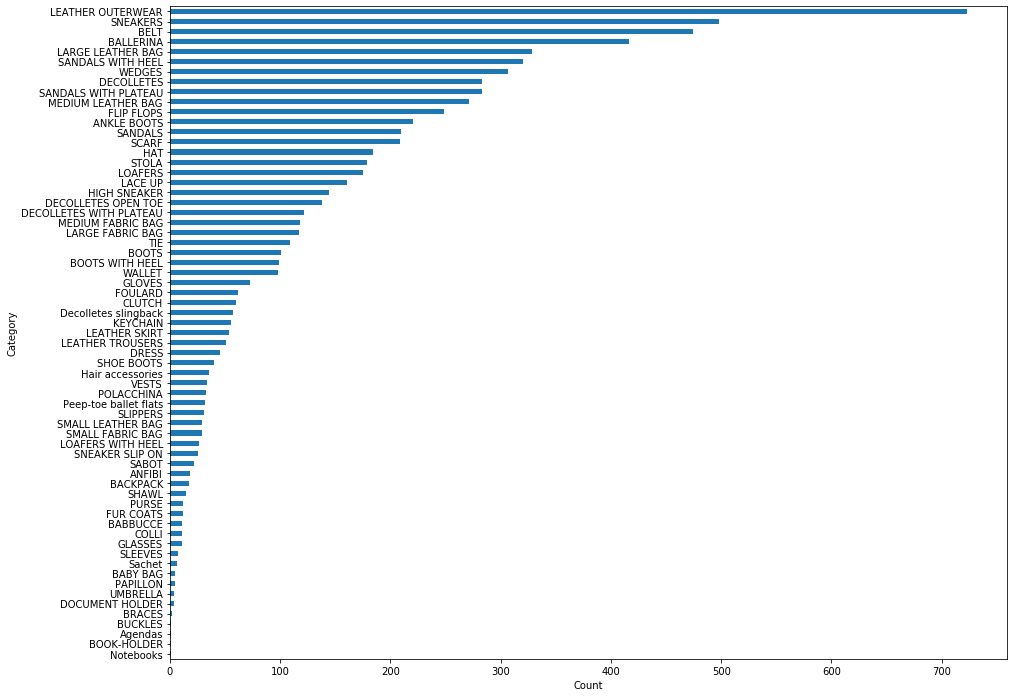

In [25]:
# Plot bar graph of all mirco categories in dataset
fig= plt.figure(figsize=(15,12))
data.micro_category.value_counts(ascending=True).plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Category')

### Visualising Images in the Dataset

In [26]:
Data_Path= '/Users/flatironschool/Downloads/part1/'

In [27]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return Data_Path+img

def load_image(img):
    return cv2.imread(img_path(img))

In [28]:
load_image('35154736FEF_resized.jpg');


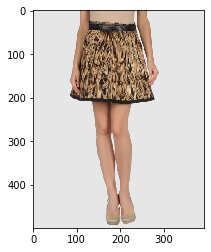

In [29]:
import cv2 as cv
from matplotlib import pyplot as plt
import pytesseract
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img = load_img(Data_Path+data.iloc[0].filename)
plt.imshow(img)

### Using Pre-Trained CNN model

To classify the fashion images, we use a model based on a deep convolutional neural networks called Resnet. ResNet is characterized by the residual block structure. This incorporates identity shortcut connections which essentially skip the training of one or more layers. In the Keras package, I loaded the ResNet-50 model and download weights pretrained on ImageNet dataset(ImageNet is a large visual database designed for use in visual object recognition software research).

In [33]:
image_path = '/Users/flatironschool/Downloads/part1/35154736FEF_resized.jpg'

In [34]:
from keras import models

im = Image.open(image_path)
width, height = im.size
# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (197, 197, 3))
base_model.trainable = False

# Add Layer Embedding
model = models.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


 ### Neural Network Embedding 

In the context of neural networks embeddings are low-dimensional, learned continuous vector representations of discrete variables. Neural network embeddings are useful because they can reduce the dimensionality of categorical variables and meaningfully represent categories in the transformed space.
Neural network embeddings have 3 primary purposes:
- Finding nearest neighbors in the embedding space. These can be used to make recommendations based on user interests or cluster categories.
- As input to a machine learning model for a supervised task.
- For visualization of concepts and relations between categories.

We can reduce the dimensonality of the input fashion images and convert them to vectors. Then use cosine similarity to find the distance between different images. When we have calculated all the images' distance to one another, we can find the closest images to an input image.

Get fashion iamages embedded

In [35]:

def get_embedding(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(197, 197))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [38]:
emb = get_embedding(model, data.iloc[0].filename)
emb.size

2048

[ 0.28380775  1.7362297   0.21887302 ...  3.6869454   2.9898915
 26.224792  ]


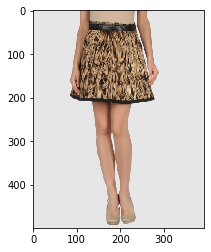

In [42]:
plt.imshow(cv2.cvtColor(load_image(data.iloc[0].filename), cv2.COLOR_BGR2RGB))
print(emb)

Get embeddings for all fashion ites in the datset 

In [43]:
%%time
import swifter


map_embeddings = data4['filename'].swifter.apply(lambda img: get_embedding(model, img))
data_embs        = map_embeddings.apply(pd.Series)

print(data_embs.shape)
data_embs.head()


(7473, 2048)
CPU times: user 2h 31min 48s, sys: 6min 45s, total: 2h 38min 33s
Wall time: 58min 59s


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.283808,1.736230,0.218873,5.499749,1.585959,1.621852,9.584253,1.673278,5.700523,0.974858,...,1.841537,4.625426,4.836455,7.109380,0.281990,0.000000,0.221036,3.686945,2.989892,26.224792
1,0.566298,0.420376,0.343046,4.930400,3.360434,7.167229,8.831626,3.375045,6.850046,0.000000,...,2.414181,4.756695,5.666263,6.907717,0.559856,1.464723,0.422878,2.897524,3.252851,15.062943
2,2.555057,3.014555,0.586020,7.338143,1.884737,7.076230,8.281777,3.887664,8.664798,0.000000,...,6.614436,2.551303,4.959482,3.889502,1.152679,1.177197,2.477158,3.358292,13.641438,25.201868
3,3.654042,10.462400,0.000000,4.951956,1.325171,2.007029,11.079943,5.120615,4.987312,0.213729,...,0.053115,4.948205,6.927123,7.370433,2.231714,2.249039,2.663607,1.873456,3.620249,16.729837
4,0.957230,8.168704,0.000000,6.320714,1.353875,0.000000,7.804029,2.165272,7.615117,0.844321,...,2.125678,3.588090,3.983064,3.655729,1.491413,0.596378,0.661688,5.482021,0.506374,12.785903


Use pairwise_distance functon with metric='cosine' which takes a vector array and returns a distance matrix.

In [44]:
from sklearn.metrics.pairwise import pairwise_distances

# Calculate distance matrix
cosine_sim = 1-pairwise_distances(data_embs, metric='cosine')
cosine_sim[:4, :4]

array([[0.9999998 , 0.82042855, 0.79321456, 0.823589  ],
       [0.82042855, 0.99999976, 0.80721617, 0.84462446],
       [0.79321456, 0.80721617, 1.        , 0.83191216],
       [0.823589  , 0.84462446, 0.83191216, 0.99999976]], dtype=float32)

Function that get clothes recommendations based on the cosine similarity


In [45]:
indices = pd.Series(range(len(data4)), index=data4.index)
indices

# Function that get clothes recommendations based on the cosine similarity score of micro categories
def get_recommender(idx, data, top_n = 6):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

get_recommender(2993, data4, top_n = 6)

(Int64Index([2999, 2930, 3014, 2997, 2596, 2494], dtype='int64'),
 [0.89842683, 0.8852705, 0.84515655, 0.81852424, 0.8171154, 0.8120699])

Index of the fashion image from the dataset is used a reference input. Using the get_recommender function, this finds the most siilar 6 images and plots them below the input image.

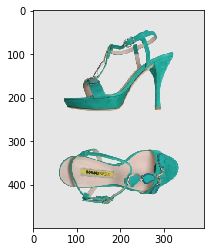

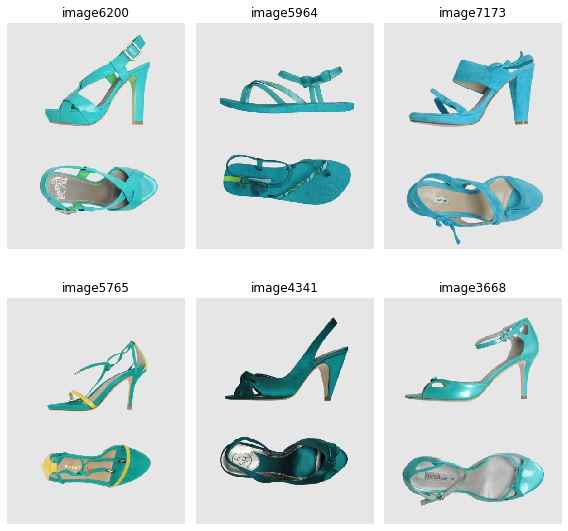

In [104]:
# Idx Item to Recommender
idx_ref = 3849


# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, data, top_n = 6)

# Plot
plt.imshow(cv2.cvtColor(load_image(data4.iloc[idx_ref].filename), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'image'+str(i): load_image(row.filename) for i, row in data4.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

In [57]:
from sklearn.manifold import TSNE
import seaborn as sns

In [75]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=3000, init='pca')
tsne_results = tsne.fit_transform(data_embs)

In [76]:
tsne.n_iter

3000

In [77]:
data['tsne-2d-one'] = tsne_results[:,0]
data['tsne-2d-two'] = tsne_results[:,1]

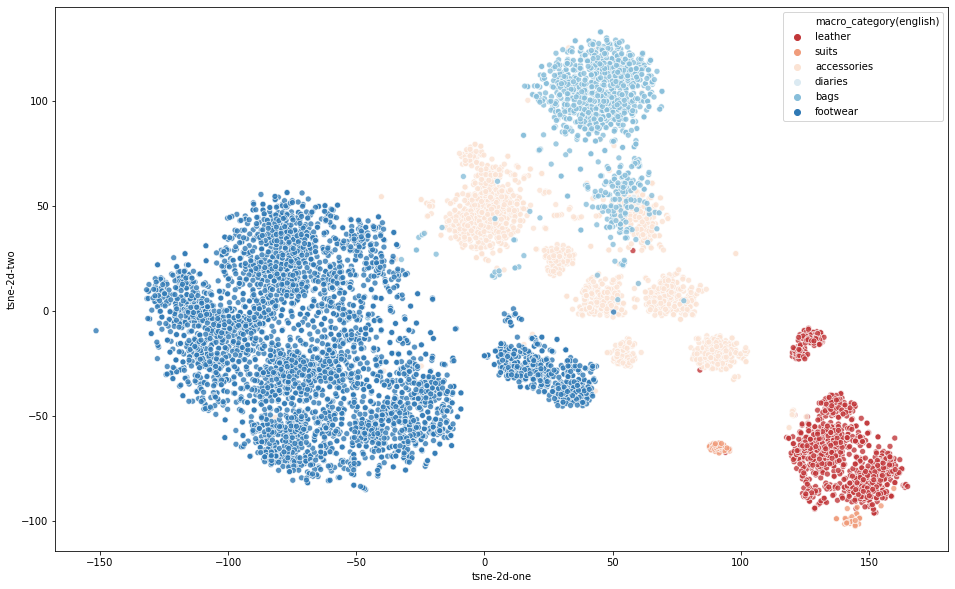

In [82]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="macro_category(english)",
                data=data4,
                legend="full",
                palette="RdBu",
                alpha=0.8)